In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("../src/wolfram_sarscov2.tsv", sep ="\t")
df.head()

,Accession,Species,Genus,Family,Length,Authors,Publications,Host,BioSample,Sequence,CollectionDate,ReleaseDate,GeographicLocation,NucleotideStatus,GenBankTitle,IsolationSource,Country,InclusionDate
0,MT263469,Severe acute respiratory syndrome-related coro...,Betacoronavirus,"Entity[""Species"", ""Family:Coronaviridae""]",29857,"Roychoudhury,P., Greninger,A., Jerome,K.","Missing[""NoInput""]","Entity[""Species"", ""Species:HomoSapiens""]",NaN,TTCTCTAAACGAACTTTAAAATCTGTGTGGCTGTCACTCGGCTGCA...,"DateObject[{2020, 3, 23}, ""Day"", ""Gregorian"", ...","DateObject[{2020, 3, 31}, ""Day"", ""Gregorian"", ...","Entity[""Country"", ""UnitedStates""]",GenBank,Severe acute respiratory syndrome coronavirus ...,NaN,"Entity[""Country"", ""UnitedStates""]","DateObject[{2020, 3, 31}, ""Day"", ""Gregorian"", ..."
1,MT263468,Severe acute respiratory syndrome-related coro...,Betacoronavirus,"Entity[""Species"", ""Family:Coronaviridae""]",29892,"Roychoudhury,P., Greninger,A., Jerome,K.","Missing[""NoInput""]","Entity[""Species"", ""Species:HomoSapiens""]",NaN,GTTTATACCTTCCCAGGTAACAAACCATYHAACTTTCGATCTCTTG...,"DateObject[{2020, 3, 23}, ""Day"", ""Gregorian"", ...","DateObject[{2020, 3, 31}, ""Day"", ""Gregorian"", ...","Entity[""Country"", ""UnitedStates""]",GenBank,Severe acute respiratory syndrome coronavirus ...,NaN,"Entity[""Country"", ""UnitedStates""]","DateObject[{2020, 3, 31}, ""Day"", ""Gregorian"", ..."
2,MT263467,Severe acute respiratory syndrome-related coro...,Betacoronavirus,"Entity[""Species"", ""Family:Coronaviridae""]",29853,"Roychoudhury,P., Greninger,A., Jerome,K.","Missing[""NoInput""]","Entity[""Species"", ""Species:HomoSapiens""]",NaN,TGTCAGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTGGCTGTC...,"DateObject[{2020, 3, 23}, ""Day"", ""Gregorian"", ...","DateObject[{2020, 3, 31}, ""Day"", ""Gregorian"", ...","Entity[""Country"", ""UnitedStates""]",GenBank,Severe acute respiratory syndrome coronavirus ...,NaN,"Entity[""Country"", ""UnitedStates""]","DateObject[{2020, 3, 31}, ""Day"", ""Gregorian"", ..."
3,MT263466,Severe acute respiratory syndrome-related coro...,Betacoronavirus,"Entity[""Species"", ""Family:Coronaviridae""]",29634,"Roychoudhury,P., Greninger,A., Jerome,K.","Missing[""NoInput""]","Entity[""Species"", ""Species:HomoSapiens""]",NaN,CTTCTGCAGGCTGCTTACGGTTTCGTCCGTGTTGCAGCCGATCATC...,"DateObject[{2020, 3, 23}, ""Day"", ""Gregorian"", ...","DateObject[{2020, 3, 31}, ""Day"", ""Gregorian"", ...","Entity[""Country"", ""UnitedStates""]",GenBank,Severe acute respiratory syndrome coronavirus ...,NaN,"Entity[""Country"", ""UnitedStates""]","DateObject[{2020, 3, 31}, ""Day"", ""Gregorian"", ..."
4,MT263465,Severe acute respiratory syndrome-related coro...,Betacoronavirus,"Entity[""Species"", ""Family:Coronaviridae""]",29867,"Roychoudhury,P., Greninger,A., Jerome,K.","Missing[""NoInput""]","Entity[""Species"", ""Species:HomoSapiens""]",NaN,ATAAACTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAA...,"DateObject[{2020, 3, 23}, ""Day"", ""Gregorian"", ...","DateObject[{2020, 3, 31}, ""Day"", ""Gregorian"", ...","Entity[""Country"", ""UnitedStates""]",GenBank,Severe acute respiratory syndrome coronavirus ...,NaN,"Entity[""Country"", ""UnitedStates""]","DateObject[{2020, 3, 31}, ""Day"", ""Gregorian"", ..."


# Dataset exploration

In [6]:
df[df.Length > 25000].GeographicLocation.unique()

array(['Entity["Country", "UnitedStates"]', 'Entity["Country", "Peru"]',
       'Entity["Country", "Pakistan"]', 'Entity["Country", "China"]',
       'Entity["Country", "Colombia"]', 'Entity["Country", "Spain"]',
       'Entity["Country", "Japan"]', 'Entity["Country", "Vietnam"]',
       'Entity["Country", "Taiwan"]', 'Entity["Country", "Italy"]',
       'Entity["Country", "India"]', 'Entity["Country", "Brazil"]',
       'Missing["NoInput"]', 'Entity["Country", "Sweden"]',
       'Entity["Country", "Nepal"]', 'Entity["Country", "SouthKorea"]',
       'Entity["Country", "Finland"]', 'Entity["Country", "Australia"]'],
      dtype=object)

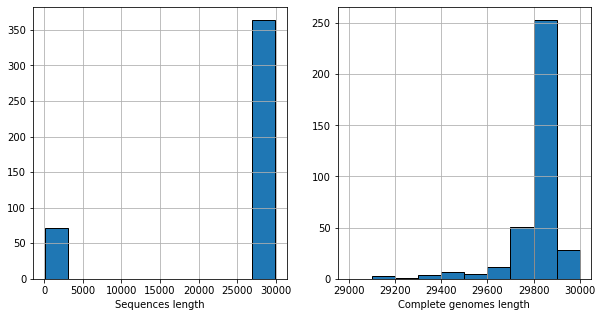

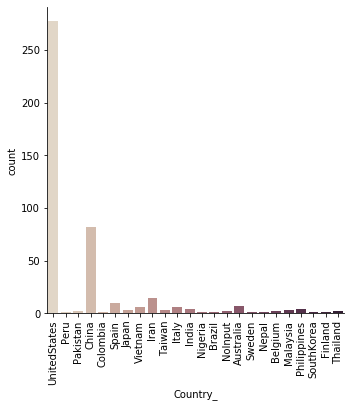

In [7]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
g1 = df.Length.hist(ax = ax[0], edgecolor="k")
g1.set_xlabel('Sequences length')
g2 = df.Length[df.Length > 25000].hist(bins=np.arange(29000,30001,100), edgecolor="k")
g2.set_xlabel('Complete genomes length')
plt.savefig("lengths.pdf")
plt.savefig("lengths.png", dpi=600)

#>350 complete genomes
#>50 partial cds

df['Country_'] = df.Country.apply(lambda s: s.split('"')[-2])
chart = sns.catplot(x="Country_", kind="count", palette="ch:.25", data=df,);
chart.set_xticklabels(rotation=90)

plt.savefig("countries.pdf")
plt.savefig("countries.png", dpi=600)

In [16]:
df.Host.unique()
#this dataset is all for home sapiens

array(['Entity["Species", "Species:HomoSapiens"]'], dtype=object)

## get corpus

In [8]:
complete_genomes = df[df.Length > 25000].Sequence.copy()

In [9]:
%%time
#let's keep the original indexing to allow lookups from the starting data
corpus = []
ordered_indexes = [] #probably overkill, but avoid forgetting the indexes to retrieve metadata

kmer_len = 4
for i, seq in complete_genomes.iteritems():
    ordered_indexes.append(i)
    corpus.append([seq[j:j+kmer_len] for j in np.arange(0, len(seq)-kmer_len)])
    
#All that is required is that the input yields one sentence (list of utf8 words) after another.
#it takes around 8 seconds

CPU times: user 7.33 s, sys: 386 ms, total: 7.71 s
Wall time: 7.95 s


## train model

In [16]:
from gensim.models import Word2Vec

size= 100
tot_epochs= 5
model = Word2Vec(sentences=corpus, min_count=1, size=size, iter=tot_epochs)


# Visualization

## summarize sentences (genomes) by making word means (or sum, whatever, their length is pretty much the same) and tSNE the results

#### make it as colors/labels are interchangeable

In [63]:
from sklearn.decomposition import IncrementalPCA    # initial reduction
from sklearn.manifold import TSNE                   # final reduction

def reduce_dimensions(model, ordered_indexes, corpus, df=df, label="Accession", color_label="Country_",
                     perplexity=30):
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    vectors = [] # positions in vector space
    labels = [] # keep track of words to label our data again later
    color_labels = []
    for i, sentence in zip(ordered_indexes, corpus):

        vectors.append(np.mean([model.wv[word] for word in sentence], axis=0))
        labels.append(df.iloc[i][label])
        color_labels.append(df.iloc[i][color_label])
        
    # convert both lists into numpy vectors for reduction
    vectors = np.asarray(vectors)
    labels = np.asarray(labels)

    # reduce using t-SNE
    vectors = np.asarray(vectors)
    tsne = TSNE(n_components=num_dimensions, random_state=0, perplexity=perplexity)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels, color_labels


x_vals, y_vals, labels, color_labels = reduce_dimensions(model, ordered_indexes, corpus, 
                                                         label="Accession", color_label="Country_")





In [39]:

np.unique(color_labels)

le = preprocessing.LabelEncoder()
le.fit(color_labels)
cmappable_labels = le.transform(color_labels)
cmappable_labels


array([16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 11, 10, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,  2,  2,  2,  2,  2,
        2, 16, 16, 16, 16, 16, 16, 16,  3, 13, 13,  7,  7,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2, 16, 16, 16, 16, 16, 16,
       16, 16, 16,  2, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16

In [60]:
from sklearn import preprocessing
def plot_with_plotly(x_vals, y_vals, labels, color_labels, plot_in_notebook=True):
    from plotly.offline import init_notebook_mode, iplot, plot
    import plotly.graph_objs as go
    from sklearn import preprocessing

    le = preprocessing.LabelEncoder()
    le.fit(color_labels)
    cmappable_labels = le.transform(color_labels)
    
    trace = go.Scatter(x=x_vals, y=y_vals, text=labels, 
                      mode='markers',
                        marker=dict(
                        size=16,
                        color=cmappable_labels, #set color equal to a variable
                        colorscale='Viridis', # one of plotly colorscales
                        showscale=True
                        ))
    data = [trace]

    if plot_in_notebook:
        init_notebook_mode(connected=True)
        iplot(data, filename='word-embedding-plot')
    else:
        plot(data, filename='word-embedding-plot.html')


def plot_with_matplotlib(x_vals, y_vals, labels, color_labels):
    import matplotlib.pyplot as plt
    import random

    random.seed(0)

    le = preprocessing.LabelEncoder()
    le.fit(color_labels)
    cmappable_labels = le.transform(color_labels)
    
    fig, ax = plt.subplots(1, figsize=(10, 10))
    unique = np.unique(color_labels)
    colors = [plt.cm.rainbow(i/float(len(unique)-1)) for i in range(len(unique))]
    for i, u in enumerate(unique):
        xi = [x_vals[j] for j  in range(len(x_vals)) if color_labels[j] == u]
        yi = [y_vals[j] for j  in range(len(x_vals)) if color_labels[j] == u]
        plt.scatter(xi, yi, c=colors[i], label=str(u))
    plt.legend()
    """
    scatter = plt.scatter(x_vals, y_vals, c=cmappable_labels, cmap='rainbow',)

    # produce a legend with the unique colors from the scatter
    legend1 = ax.legend(*[scatter.legend_elements()[0], le.inverse_transform([[x] for x in np.arange(0,17,1)])],
                    loc="lower left", title="Classes")
    ax.add_artist(legend1)
    #
    # Label randomly subsampled 25 data points
    #
    """
    indices = list(range(len(labels)))
    selected_indices = random.sample(indices, 50)
    for i in selected_indices:
        plt.annotate(labels[i], (x_vals[i], y_vals[i]))
    
    return fig,ax


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

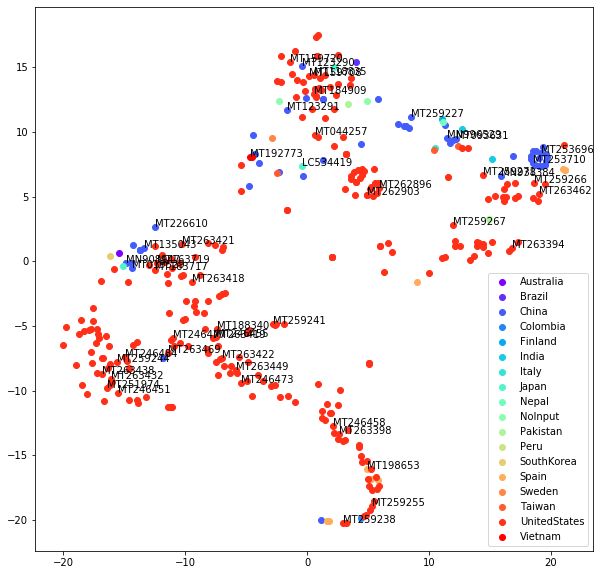

In [61]:

"""
try:
    get_ipython()
except Exception:
    plot_function = plot_with_matplotlib
else:
    plot_function = plot_with_plotly
""" 
_,_= plot_with_matplotlib(x_vals, y_vals, labels, color_labels)

plt.savefig(f"tsne_human_w2vsize_{size}_epochs_{tot_epochs}.pdf")
plt.savefig(f"tsne_human_w2vsize_{size}_epochs_{tot_epochs}.png", dpi=600)



## putting it all together

In [ ]:
param_grid = {
    'size' : [10, 50, 100, 200],
    'iter' : [5, 10, 20, 50]
}
perplexity = 5

from sklearn.model_selection import ParameterGrid
for params in ParameterGrid(param_grid):
    print(params, f'perplexity: {perplexity}')
    %time model = Word2Vec(sentences=corpus, min_count=1, **params)
    
    x_vals, y_vals, labels, color_labels = reduce_dimensions(model, ordered_indexes, corpus, 
                                                         label="Accession", color_label="Country_", 
                                                             perplexity=perplexity)
    
    plot_with_matplotlib(x_vals, y_vals, labels, color_labels)

    plt.savefig(f"grid_search_human_v0/tsne_human_w2vsize_{params['size']}_epochs_{params['iter']}_perpl_{perplexity}.pdf")
#png    plt.savefig(f"grid_search_human_v0/tsne_human_w2vsize_{params['size']}_epochs_{params['iter']}_perpl_{perplexity}.png", dpi=600)

{'iter': 5, 'size': 10} perplexity: 5
CPU times: user 46 s, sys: 501 ms, total: 46.5 s
Wall time: 19.7 s


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

{'iter': 5, 'size': 50} perplexity: 5
CPU times: user 51.1 s, sys: 285 ms, total: 51.4 s
Wall time: 19.4 s


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

{'iter': 5, 'size': 100} perplexity: 5
CPU times: user 50.9 s, sys: 277 ms, total: 51.2 s
Wall time: 19 s


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

{'iter': 5, 'size': 200} perplexity: 5
CPU times: user 1min 4s, sys: 743 ms, total: 1min 4s
Wall time: 25.3 s


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

{'iter': 10, 'size': 10} perplexity: 5
CPU times: user 1min 25s, sys: 629 ms, total: 1min 26s
Wall time: 32.7 s


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

{'iter': 10, 'size': 50} perplexity: 5
CPU times: user 1min 40s, sys: 641 ms, total: 1min 41s
Wall time: 39.3 s


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

{'iter': 10, 'size': 100} perplexity: 5
CPU times: user 1min 39s, sys: 648 ms, total: 1min 40s
Wall time: 37 s


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

{'iter': 10, 'size': 200} perplexity: 5
CPU times: user 2min 2s, sys: 675 ms, total: 2min 2s
Wall time: 44.1 s


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

{'iter': 20, 'size': 10} perplexity: 5
CPU times: user 2min 49s, sys: 1.13 s, total: 2min 50s
Wall time: 1min 2s


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

{'iter': 20, 'size': 50} perplexity: 5
CPU times: user 3min 19s, sys: 1.41 s, total: 3min 20s
Wall time: 1min 15s


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

{'iter': 20, 'size': 100} perplexity: 5
CPU times: user 3min 14s, sys: 1.17 s, total: 3min 15s
Wall time: 1min 10s


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

{'iter': 20, 'size': 200} perplexity: 5
CPU times: user 3min 58s, sys: 1.32 s, total: 3min 59s
Wall time: 1min 25s


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

{'iter': 50, 'size': 10} perplexity: 5
CPU times: user 7min 7s, sys: 3.52 s, total: 7min 10s
Wall time: 2min 46s


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

{'iter': 50, 'size': 50} perplexity: 5
CPU times: user 8min 19s, sys: 3.87 s, total: 8min 23s
Wall time: 3min 10s


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

{'iter': 50, 'size': 100} perplexity: 5
